The project was based on `House Sales in King County, USA` data available on Kaggle at [https://www.kaggle.com/harlfoxem/housesalesprediction](https://www.kaggle.com/harlfoxem/housesalesprediction).

In the first section, the data analysis process was performed. Preprocessing was also done, in which some variables were removed, as well as values that were useless or would even interfere with further research.

In the next step, dimensionality reduction was performed using `PCA` method and then clustering attempt was performed using `K-means clustering` algorithm.

In the last point, an attempt was made to predict the `price` values for individual observations using regression algorithms. Finally, the performance of the different algorithms was compared for the prepared dataset.


### Data analysis and preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv('kc_house_data.csv')

In [ ]:
df.info()

The set has 2163 observations contained in 21 variables.

5 variables (`price`, `bathrooms`, `floors`, `lat` and `long`) are of type float64.

15 variables (`id`, `bedrooms`, `sqft_living`, `sqft_lot`, `waterfront`, `view`, `condition`, `grade`, `sqft_above`, `sqft_basement`, `yr_built`, `yr_renovated`, `zipcode`, `sqft_living15`, `sqft_lot15`) are of type int64

1 variable (`date`) is of type object.

Explained variable is `price`.

The observations do not contain any empty values.




In [ ]:
df.describe()

A correlation matrix is presented below to see to what extent the different variables correlate with each other. The correlation of the variable `price` with the other variables has been taken under special consideration.

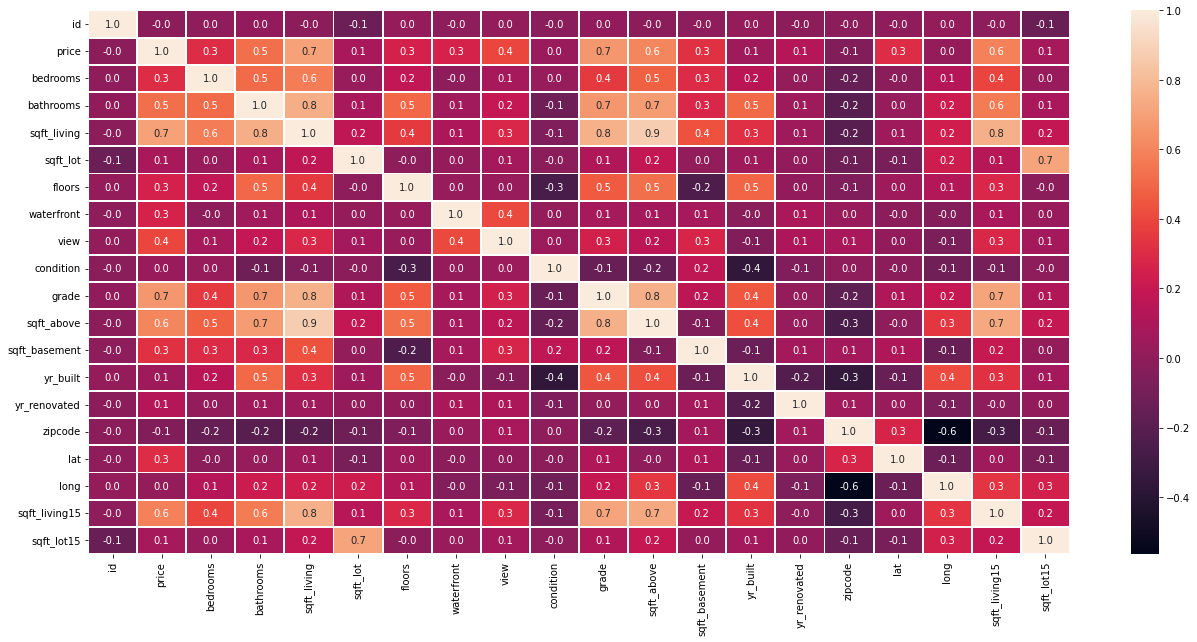

In [ ]:
fig,ax = plt.subplots(figsize=(22, 10))
sns.heatmap(df.corr(), annot=True, linewidths=.9, fmt= '.1f',ax=ax)

In [ ]:
df_corr = df.corr()
pd.DataFrame(data = np.triu(df_corr), index=None)
df_corr['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
id              -0.016762
zipcode         -0.053203
Name: price, dtype: float64

Most of the explanatory variables have a positive correlation with the `price` variable, while the `sqft_living` and `grade` variables have the highest correlation value with the explanatory variable. 

Some variables that were found to be useless for future research were removed from further consideration.

In [ ]:
df = df.drop(['date', 'id'], axis=1)

The histogram and box plot of the variable `price' are shown below.




/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


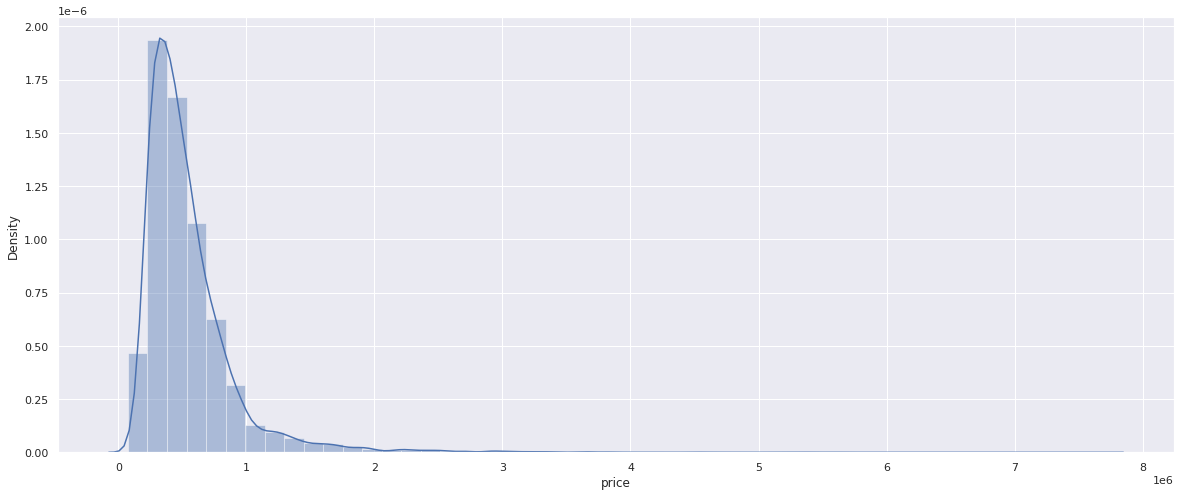

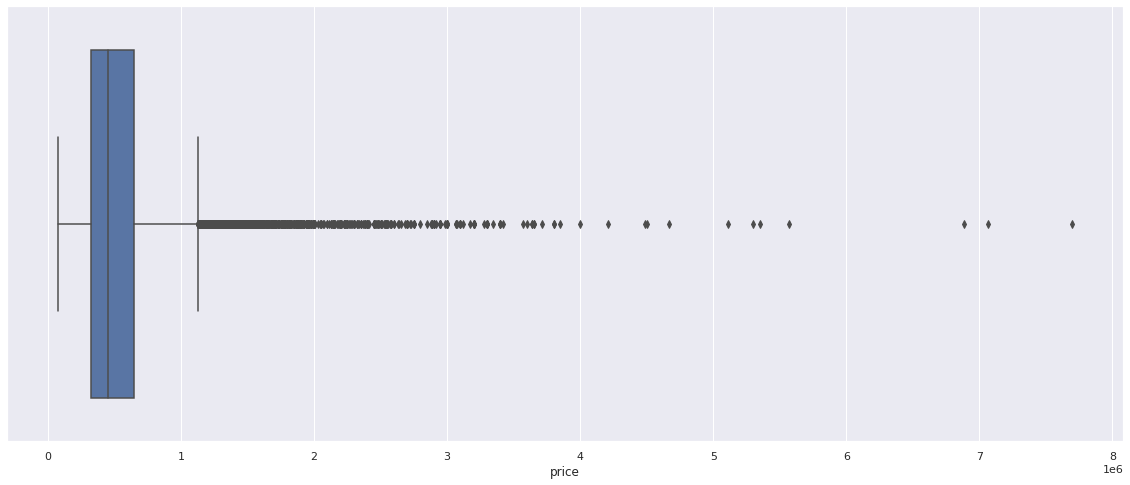

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
g=sns.distplot(df.price)

fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(df.price)

The distribution is slightly right skewed. Some slightly outlier observations can be observed, so the decision was made to remove these values.

In [ ]:
df = df[df.price<2500000]

Below are plots of all the variables with the variable `price`. These will allow you to identify some outliers, if any.

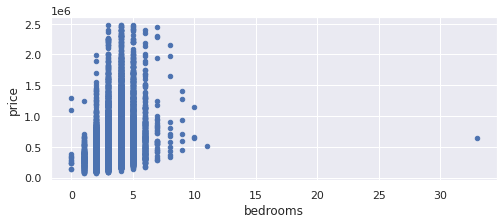

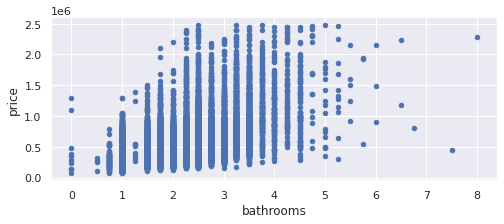

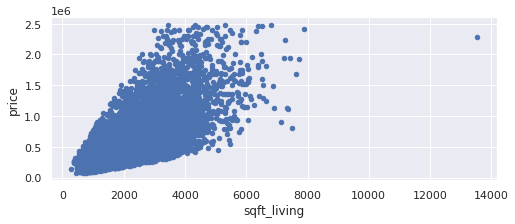

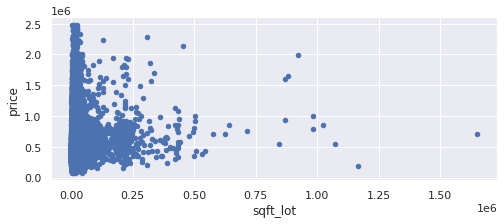

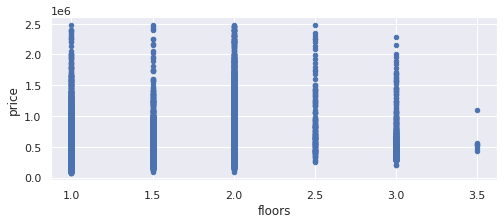

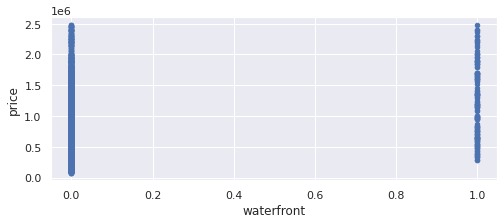

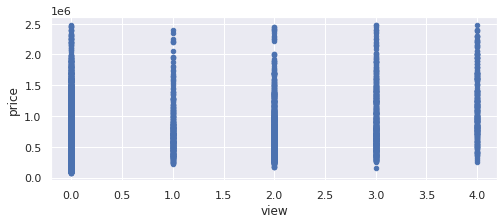

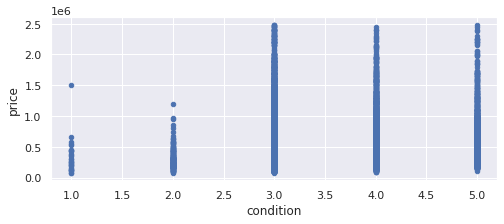

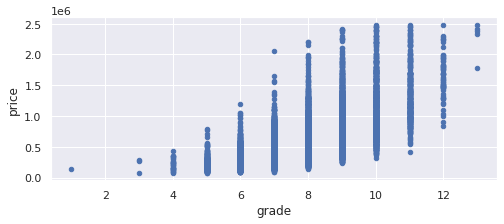

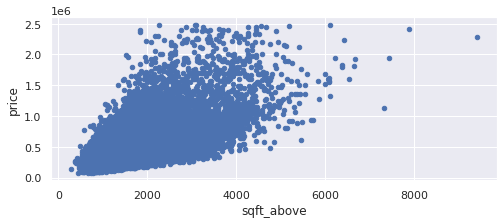

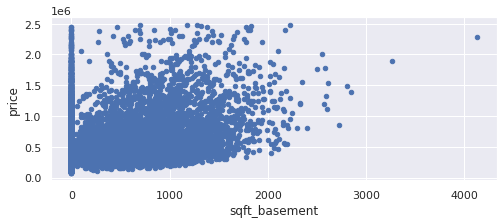

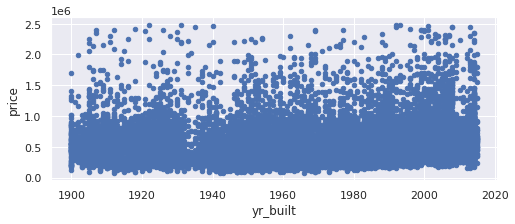

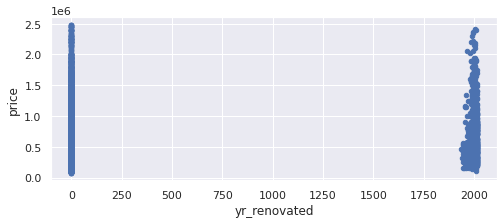

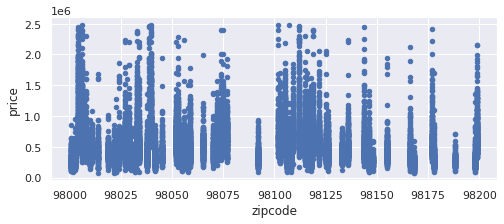

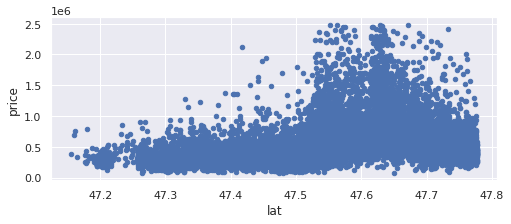

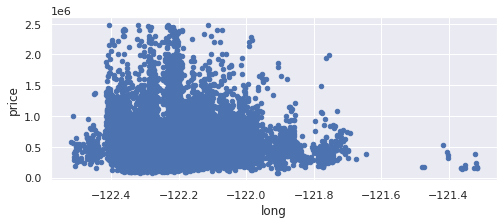

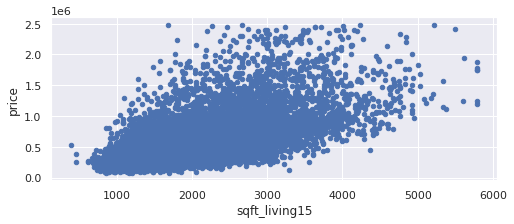

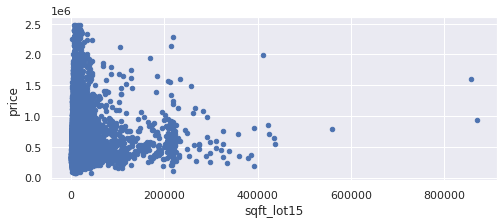

In [ ]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
plt.rcParams["figure.figsize"] = (8,3)
kolumny=df.columns[1:]
for k in kolumny:
  df.plot(kind='scatter',x=k,y='price') 

Based on the above graphs, four outliers were identified. It was decided to remove them.

In [ ]:
df[(df.bedrooms >30) | (df.sqft_living>12000) | (df.sqft_lot15>800000)].shape

(4, 19)

In [ ]:
df = df.drop(df[(df.bedrooms >30) | (df.sqft_living>12000) | (df.sqft_lot15>800000)].index)

One of the categorical variables that has the highest correlation with `price` is the `grade` variable.
The following shows how each value affects price.

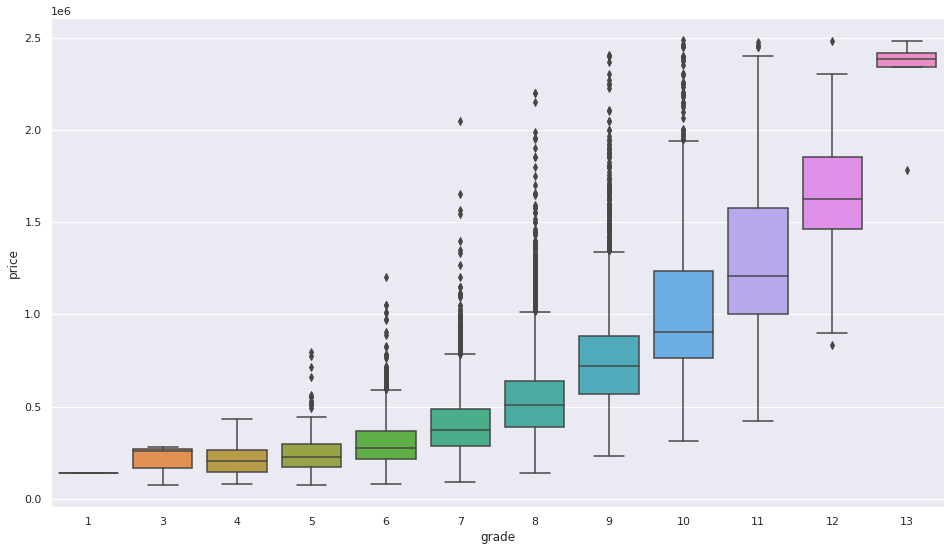

In [ ]:
sns.boxplot(data = df, x = 'grade', y = 'price')

As outlined above, typically an increase in the `grade` variable results in an increase in `price`.

### Dimensionality reduction and clustering

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
scaler= StandardScaler()
df_scaled = scaler.fit_transform(df)

In [ ]:
pca = PCA()
pca.fit(df_scaled)

PCA()

The first step in dimensionality reduction using the PCA method is to select the number of features on which to base further research. To assist in this task, a cumulative variance plot was used. It shows the percentage of variance explanation (y axis) depending on the number of components (x axis).

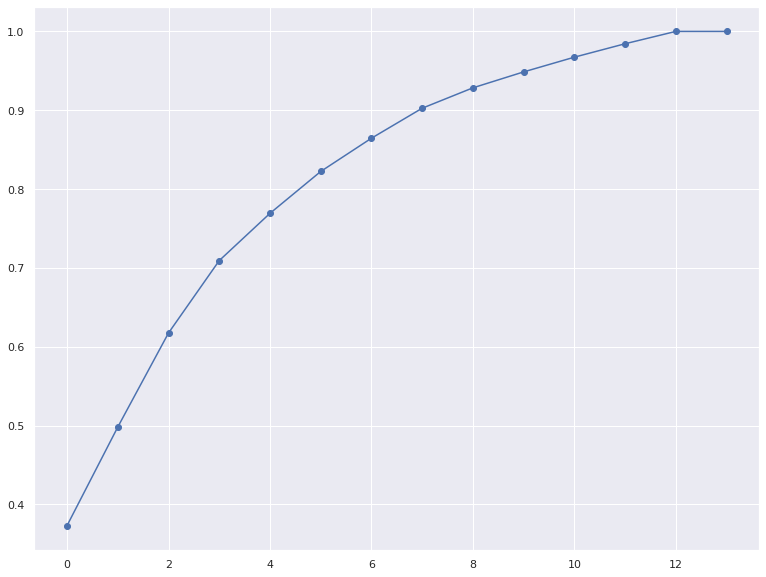

In [ ]:
plt.figure(figsize=(13,10))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker='o')

The rule of thumb is to choose a number of features that explains about 80% of the variance. In this case it will be the number `6`.


In [ ]:
pca = PCA(6)
pca.fit(df_scaled)

PCA(n_components=6)

In [ ]:
scores_pca = pca.transform(df_scaled)

The values when written to the table are as follows:

In [ ]:
housing_pca = pd.DataFrame(pca.fit_transform(df_scaled), columns=['pc1','pc2', 'pc3', 'pc4', 'pc5', 'pc6'])
housing_pca.head()

,pc1,pc2,pc3,pc4,pc5,pc6
0,-2.541409,-0.299553,0.231669,0.219735,0.484507,-0.163186
1,0.232788,-0.816412,0.018136,0.109697,0.438574,0.163877
2,-2.835428,-0.085045,0.546671,0.584965,0.415823,-1.113994
3,-0.509735,1.753977,-1.657504,-1.641402,-1.014742,0.971828
4,-0.697962,-0.412474,0.161450,0.181566,0.278811,-0.524406


Clustering was then performed using the `K-means' algorithm. This was done based on the results obtained from principal component analysis.

The first step is to determine the number of groups.

In [ ]:
from sklearn.cluster import KMeans

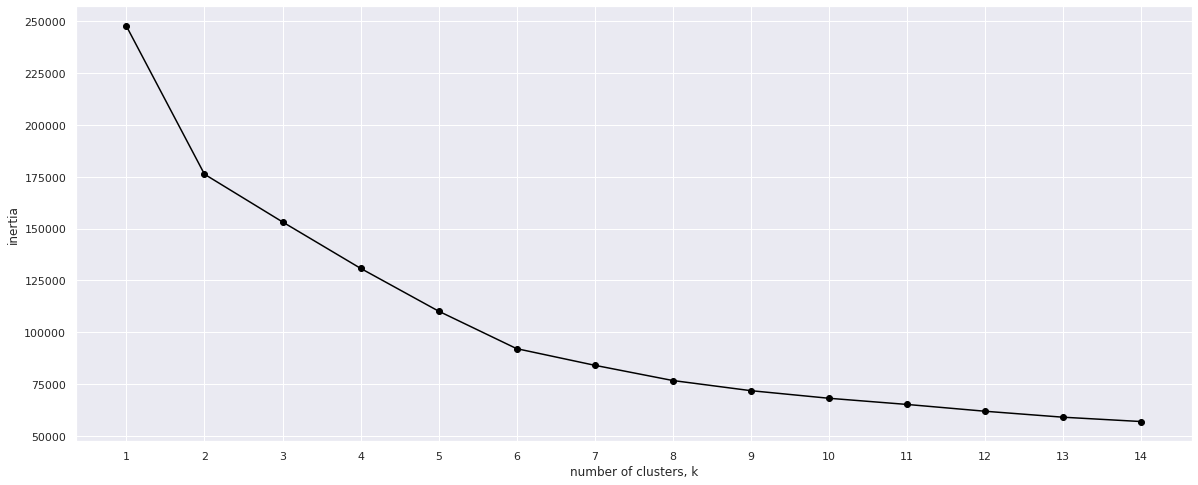

In [ ]:
ks = range(1, 15)
inertias = []
for k in ks:

    model = KMeans(n_clusters=k, random_state=999)
    model.fit(scores_pca)
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

The first way to evaluate the optimal number of clusters is the elbow rule. In the graph above, called the elbow graph, the sum of the variances as the
division into an increasing number of clusters decreases. The optimal number of groups is at the point where the sum of the variances stops decreasing rapidly.  This place is the so-called elbow.

In the above graph, it is hard to explicitly choose the above location, however we can assume that it will be number 6 on the x-axis.

In addition to the elbow graph, a line graph representing the Silhouette score was also used.


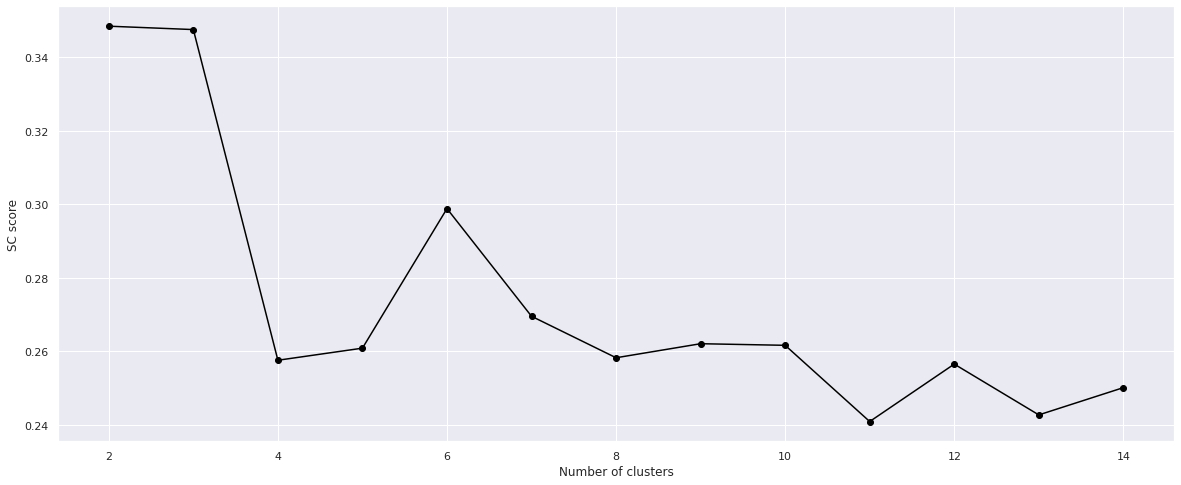

In [ ]:
from sklearn.metrics import silhouette_score
ks = range(2, 15)
sc = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state = 999).fit(scores_pca)
    labels = kmeans.predict(scores_pca)
    sc.append(silhouette_score(scores_pca, labels))


plt.plot(ks, sc, '-o', color='black')
plt.xlabel('Number of clusters')
plt.ylabel('SC score')

plt.show()

Based on the elbow plot and Silhouette score value plot for the given cluster numbers, it was decided to select 6 clusters for the K-means method

In [ ]:
kmeans = KMeans(n_clusters = 6, random_state = 999)
kmeans.fit(scores_pca)
df['KMeansLabel'] = kmeans.predict(scores_pca)


In order to present a visualization of the clusters on the 2d plane, the first 2 features obtained during the PCA analysis were selected.

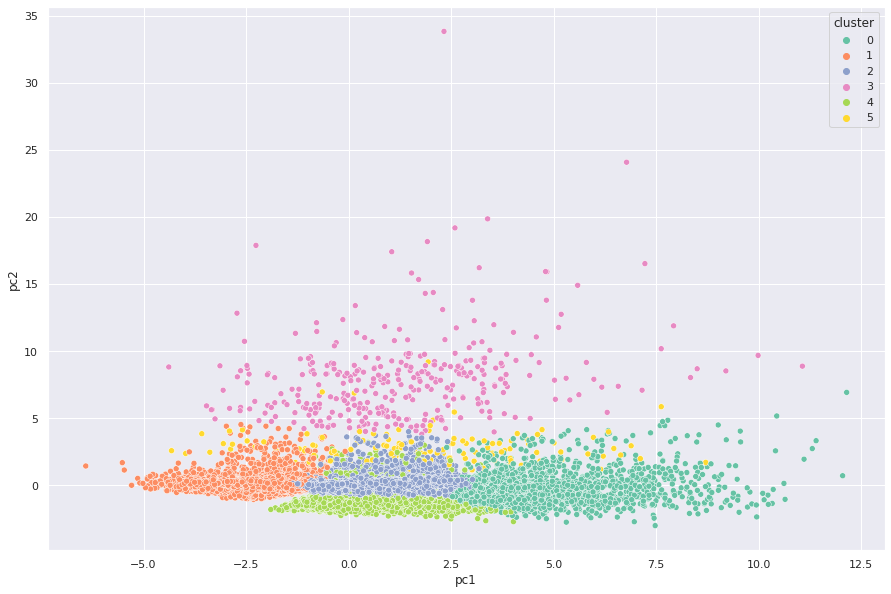

In [ ]:
import seaborn as sns
plt.figure(figsize = (15,10))
housing_pca['cluster'] = kmeans.labels_
sns.scatterplot(housing_pca.pc1,housing_pca.pc2, hue=housing_pca.cluster, palette = 'Set2')

The x-axis shows the values of pc1, while the y-axis shows the values of pc2.

In the visualization shown, you can see that some clusters are somewhat isolated from others (e.g. 0, 1), but you can also see clusters that look like they overlap. To prevent this effect, a 3D graph has been created below, with the first 3 features obtained during the PCA analysis marked on each axis.

**Note, the graph may not display correctly in the Jupyter environment and in an HTML file, best opened in Google Colab.**

In [ ]:
import plotly.express as px
housing_pca['cluster']=housing_pca['cluster'].astype(str)
fig = px.scatter_3d(housing_pca, x='pc1', y='pc2', z='pc3',
              color='cluster')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In the interactive 3D plot shown above, you can see that the clusters are isolated from each other, there is no longer an "overlap" phenomenon as in 2D projection.

The following table shows the average values of each feature (from the dataset) for each cluster.

In [ ]:
df.groupby('KMeansLabel').mean().round(2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
KMeansLabel,,,,,,,,,,,,,,,,,,,
0,1060659.21,4.13,3.10,3641.73,19562.86,1.92,0.0,0.74,3.25,9.63,3176.83,464.90,1987.70,128.94,98063.52,47.60,-122.16,3099.05,15619.85
1,548036.95,3.86,2.23,2294.46,12127.01,1.10,0.0,0.34,3.80,7.51,1463.78,830.68,1959.13,81.61,98083.32,47.58,-122.25,2010.10,10778.49
2,503888.85,3.52,2.47,2189.59,9460.90,2.01,0.0,0.07,3.13,7.97,2134.90,54.69,1990.92,74.27,98066.63,47.54,-122.18,2082.71,8711.05
3,353956.73,2.75,1.44,1319.22,9254.41,1.16,0.0,0.06,3.46,6.81,1199.21,120.01,1956.52,69.16,98089.52,47.55,-122.25,1511.05,8495.09
4,605144.90,3.31,2.35,2644.68,244892.41,1.55,0.0,0.51,3.31,8.07,2415.13,229.55,1982.68,86.26,98042.53,47.47,-122.03,2356.82,177430.50
5,1216589.17,3.11,2.38,2623.73,25060.75,1.60,1.0,3.75,3.55,8.30,2088.97,534.76,1958.48,550.43,98107.17,47.52,-122.30,2443.71,22932.12


The purpose of creating the above table was to illustrate what characteristics describe each cluster. 

It can be seen that all clusters differ in their `price` value. Only clusters 1 and 2 have a somewhat similar `price` value.

The most noteworthy cluster here is cluster number 0, where the average value of number of bedrooms and bathrooms is the highest. Also the price is quite high here, so it can be considered that this group contains houses with a large number of rooms of a higher class (`grade`).

Cluster number 2 is distinguished by the average value of `floors`, which means that there may be many storied houses in this group. Note, however, that the average value of `condition` is the lowest here, which partly explains the second lowest average price among all clusters.

Cluster number 3 has the lowest average price. This can be explained by the fact that also the number of bathrooms and bedrooms is the lowest here. The average area is also the lowest among all clusters. This may mean that this group concentrates low-cost houses with low area and class.

Cluster number 5 has the highest average price. However, it should be noted that the other variables do not take prominent values in this class except the `waterfront` column. This could mean that this group clusters records with a value of the `waterfront` variable equal to 1.



# Price predicition based on regression algorithms

In this step, predictions were made using the following algorithms:

* XGBoost Regressor
* Linear Regression
* Polynomial Regression
* Ridge Regression
* Elastic Net Regression
* Decision Tree Regressor
* Random Forest Regressor
* AdaBoost Regressor
* Gradient Boosting Regressor

For prediction, hyperparameters were tuned in each algorithm. However, it should be noted that they are probably not optimal in most cases, and it is very possible that better results could be obtained in some cases in the future.

Finally, the performance of the individual algorithms was summarized using R²





In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [ ]:
X = df.drop(['price'], axis = 1)
y = df['price']

In [ ]:
scaler = StandardScaler()
X_s = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_s,y, test_size =0.3)

In [ ]:
xgb_model = xgb.XGBRegressor(subsample=0.75, max_depth=7)
xgb_model.fit(X_train,y_train)
xgb_predict = xgb_model.predict(X_test)
xgb_score = r2_score(y_test,xgb_predict)


In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train,y_train)
linear_model_predict = linear_model.predict(X_test)
linear_score = r2_score(y_test,linear_model_predict)


In [ ]:
ridge_model = Ridge(alpha=5)
ridge_model.fit(X_train,y_train)
ridge_model_predict = ridge_model.predict(X_test)
ridge_score = r2_score(y_test,ridge_model_predict)


In [ ]:
elasticnet_model = ElasticNet(.05)
elasticnet_model.fit(X_train,y_train)
elasticnet_model_predict = elasticnet_model.predict(X_test)
elasticnet_score = r2_score(y_test,elasticnet_model_predict)


In [ ]:
tree_reg = DecisionTreeRegressor(max_depth=10)
tree_reg.fit(X_train,y_train)
tree_reg_predict = tree_reg.predict(X_test)
tree_reg_score = r2_score(y_test,tree_reg_predict)


In [ ]:
rfr = RandomForestRegressor(n_estimators=400,random_state=0)
rfr.fit(X_train,y_train)
rfr_predict = rfr.predict(X_test)
rfr_score = r2_score(y_test,rfr_predict)


In [ ]:
adaboost = AdaBoostRegressor(n_estimators=50, learning_rate=0.2,loss='exponential')
adaboost.fit(X_train,y_train)
adaboost_predict = adaboost.predict(X_test)
adaboost_score = r2_score(y_test,adaboost_predict)

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=400, max_depth=5, loss='squared_error',min_samples_split=2,learning_rate=0.1)
gbr.fit(X_train,y_train)
gbr_predict = gbr.predict(X_test)
gbr_score = r2_score(y_test,gbr_predict)


In [ ]:
print("------------- R² score poszczególnych modeli ----------------\n")
print(f'XGBoost Regressor R² Score        :   {xgb_score}\n')
print(f'Linear Regression R² Score        :   {linear_score}\n')
print(f'Elasticnet Regression R² Score    :   {elasticnet_score}\n')
print(f'Decision Tree  Regressor R² Score :   {tree_reg_score}\n')
print(f'Random Forest Regressor R² Score  :   {rfr_score}\n')
print(f'Adaboost R² Regressor Score       :   {adaboost_score}\n')
print(f'Gradient Boost  Regressor R² Score:   {gbr_score}\n')

------------- R² score poszczególnych modeli ----------------

XGBoost Regressor R² Score        :   0.8909458619426048

Linear Regression R² Score        :   0.7051913974729922

Elasticnet Regression R² Score    :   0.704933241678467

Decision Tree  Regressor R² Score :   0.7800333629117309

Random Forest Regressor R² Score  :   0.8708943614485692

Adaboost R² Regressor Score       :   0.7103564039422476

Gradient Boost  Regressor R² Score:   0.8941868537540093



In summary, the best algorithm in terms of R² for the prepared dataset is `Gradient Boost Regressor`, which received an R² score of **0.894**. An almost identical score was given to `XGBoost`, which stands for Extreme Gradient Boosting and is an efficient implementation of the Gradient Boost algorithm. In this case, the R² was **0.890**. A slightly worse result was achieved by `Random Forest Regressor` - **0.87**. All other algorithms obtained significantly lower results. Only the `Decision Tree Regressor` algorithm stands out with an R² of **0.78**. The rest of the algorithms score in the neighborhood of 0.7